In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
dataset=tfds.list_builders()
print("food101" in dataset)

True


In [3]:
try:
    (train_data, test_data), ds_info = tfds.load(
        name="food101",
        with_info=True,
        as_supervised=True,
        shuffle_files=True,
        split=["train", "validation"]
    )
except Exception as e:
    print(f"Error: {e}")

In [4]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [5]:
class_name=ds_info.features["label"].names

In [6]:
class_name=ds_info.features["label"].names
class_name[:20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

In [7]:
train_one_sample=train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Image Shape: (512, 289, 3) Image DataType: <dtype: 'uint8'> Target Class: 45 Target Class Name: frozen_yogurt


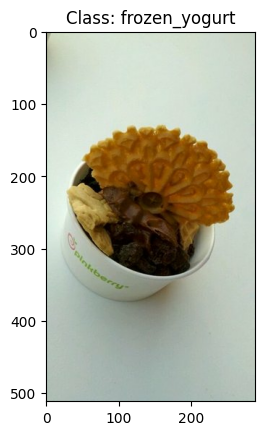

In [8]:
import matplotlib.pyplot as plt

for image, label in train_one_sample:
    print(f"Image Shape: {image.shape}",
          f"Image DataType: {image.dtype}",
          f"Target Class: {label}",
          f"Target Class Name: {class_name[label]}")

    plt.imshow(image)
    plt.title(f"Class: {class_name[label]}")
    plt.show()


In [9]:
image

<tf.Tensor: shape=(512, 289, 3), dtype=uint8, numpy=
array([[[145, 151, 125],
        [157, 163, 137],
        [159, 165, 139],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [197, 207, 198]],

       [[146, 152, 126],
        [156, 162, 136],
        [158, 164, 138],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 200]],

       [[150, 156, 130],
        [155, 161, 135],
        [157, 163, 137],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 198]],

       ...,

       [[173, 186, 177],
        [174, 187, 178],
        [176, 189, 180],
        ...,
        [181, 197, 187],
        [181, 197, 187],
        [178, 195, 187]],

       [[176, 187, 179],
        [176, 187, 179],
        [176, 189, 180],
        ...,
        [182, 198, 188],
        [182, 198, 188],
        [180, 197, 189]],

       [[178, 189, 181],
        [177, 188, 180],
        [175, 188, 179],
        ...,
        [179, 195, 18

In [10]:
def preprocess_image(image,label, target_size=224):
    image=tf.image.resize(image,[target_size,target_size])
    return tf.cast(image,tf.float64),label

In [11]:
preprocessed_image = preprocess_image(image, label)[0]
print(f"Image before preprocessing: {image.shape}")
print(f"Image after preprocessing: {preprocessed_image.shape}")

Image before preprocessing: (512, 289, 3)
Image after preprocessing: (224, 224, 3)


In [12]:
train_data=train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data=train_data.shuffle(buffer_size=100).batch(batch_size=8).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.map(preprocess_image,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=8).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [14]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras import mixed_precision, layers
from tensorflow.keras.applications import EfficientNetB2,EfficientNetV2B3
mixed_precision.set_global_policy("mixed_float16")

## **EfficientNet B2**

31790344/31790344 [==============================] - 0s 0us/step


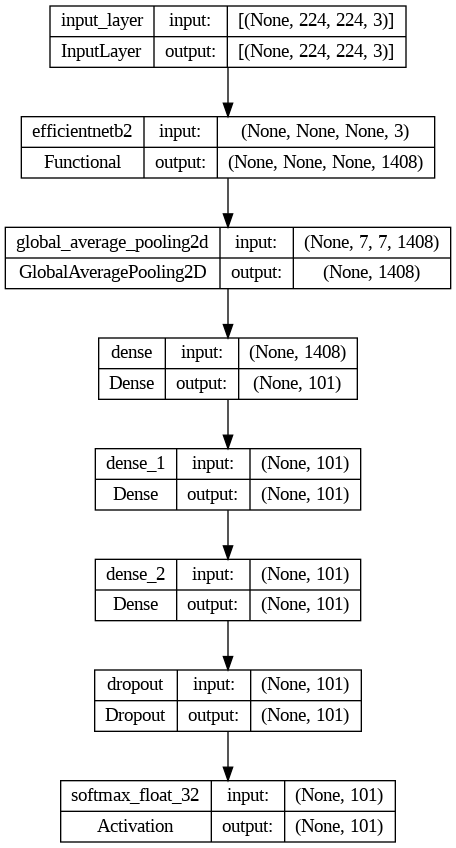

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
input_shape = (224, 224, 3)
base_model = EfficientNetB2(include_top=False,weights='imagenet')
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_name))(x)
x = layers.Dense(len(class_name))(x)
x = layers.Dense(len(class_name))(x)
x = layers.Dropout(.1)(x)
outputs = layers.Activation('softmax', name='softmax_float_32',dtype=tf.float32)(x)
model = tf.keras.Model(inputs, outputs)
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
reduce_lr= tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,
                                                monitor='val_accuracy',
                                                min_lr=1e-5,
                                                patience=0,
                                                verbose=1)
early_stopping = EarlyStopping(verbose=1, monitor="val_accuracy", patience=0, restore_best_weights=True)
plot_model(model, show_shapes=True)

In [16]:
feature_extract = model.fit(
    train_data,
    epochs=20,
    steps_per_epoch=(len(train_data)),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[reduce_lr,early_stopping]
)

Epoch 1/20
9469/9469 [==============================] - 217s 22ms/step - loss: 2.5162 - accuracy: 0.4376 - val_loss: 1.5134 - val_accuracy: 0.6298 - lr: 1.0000e-04
Epoch 2/20
9469/9469 [==============================] - 203s 21ms/step - loss: 1.8515 - accuracy: 0.5624 - val_loss: 1.2944 - val_accuracy: 0.6638 - lr: 1.0000e-04
Epoch 3/20
9469/9469 [==============================] - 208s 22ms/step - loss: 1.6918 - accuracy: 0.5924 - val_loss: 1.1990 - val_accuracy: 0.6882 - lr: 1.0000e-04
Epoch 4/20
9469/9469 [==============================] - 206s 22ms/step - loss: 1.5942 - accuracy: 0.6150 - val_loss: 1.1450 - val_accuracy: 0.6908 - lr: 1.0000e-04
Epoch 5/20
9469/9469 [==============================] - 202s 21ms/step - loss: 1.5212 - accuracy: 0.6299 - val_loss: 1.1155 - val_accuracy: 0.7075 - lr: 1.0000e-04
Epoch 6/20
9468/9469 [============================>.] - ETA: 0s - loss: 1.4715 - accuracy: 0.6407
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Resto

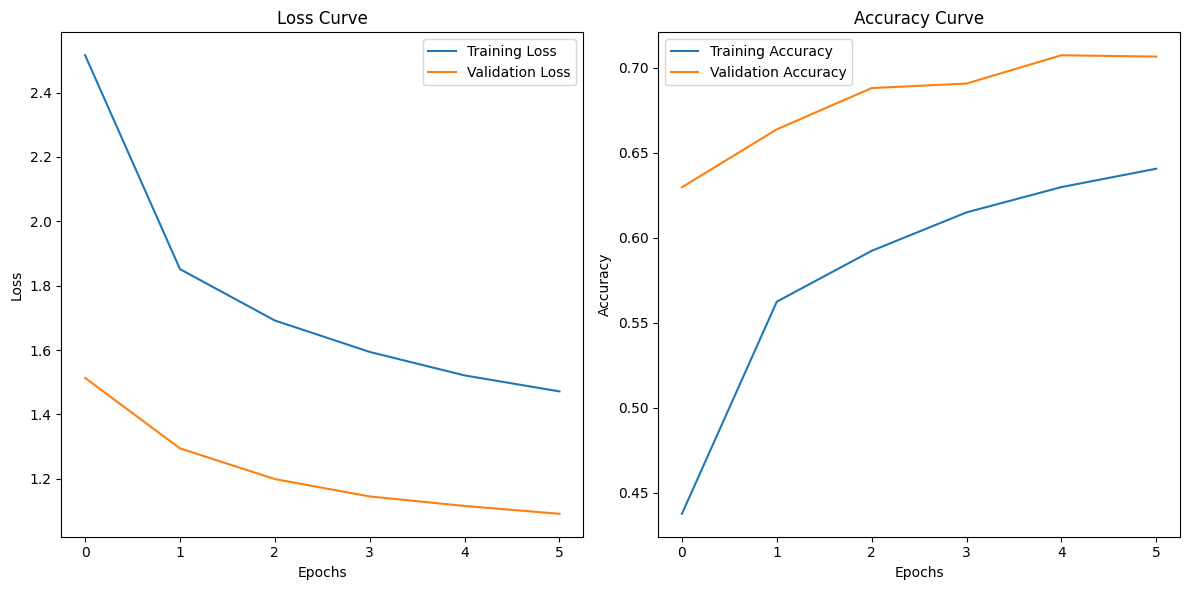

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(feature_extract.history['loss'], label='Training Loss')
plt.plot(feature_extract.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(feature_extract.history['accuracy'], label='Training Accuracy')
plt.plot(feature_extract.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [18]:
result=model.evaluate(test_data)
result

3157/3157 [==============================] - 59s 19ms/step - loss: 1.1248 - accuracy: 0.7021


[1.1248167753219604, 0.7020593881607056]